![lop](../../images/logo_diive1_128px.png)

<span style='font-size:40px; display:block;'>
<b>
    Random forest parameter optimization
</b>
</span>

---
**Notebook version**: `1` (16 Sep 2023)  
Example notebook for the class `pkgs.gapfilling.randomforest_ts.RandomForestTS` using the time series processing library `diive`.  
**Author**: Lukas Hörtnagl (holukas@ethz.ch)  


</br>

---

# **Background**

- Finding optimal model parameters

</br>

---

# **Setup**

## User settings
`TARGET_COL` ... name of the time series that is gap-filled  
`subsetcols` ... list of columns included in the random forest model, target must also be listed here

All columns that are not the target will be used as features/predictors during model building.

In [1]:
TARGET_COL = 'NEE_CUT_REF_orig'
subsetcols = [TARGET_COL, 'Tair_f', 'VPD_f', 'Rg_f']

## Imports
- This notebook uses `diive` ([source code](https://gitlab.ethz.ch/diive/diive)) to check eddy covariance fluxes for quality

In [2]:
import importlib.metadata
from datetime import datetime
from diive.configs.exampledata import load_exampledata_parquet
from diive.pkgs.gapfilling.randomforest_ts import OptimizeParamsRFTS
import matplotlib.pyplot as plt
from diive.core.plotting.heatmap_datetime import HeatmapDateTime
from diive.core.dfun.stats import sstats  # Time series stats
from diive.core.plotting.timeseries import TimeSeries  # For simple (interactive) time series plotting

dt_string = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"This page was last modified on: {dt_string}")
version_diive = importlib.metadata.version("diive")
print(f"diive version: v{version_diive}")

Loading BokehJS ...

This page was last modified on: 2023-09-17 00:51:56
diive version: v0.60.0


### Show docstring for `RandomForestTS`

In [3]:
print(OptimizeParamsRFTS.__name__)
print(OptimizeParamsRFTS.__doc__)

OptimizeParamsRFTS

    Optimize parameters for random forest model

    


</br>

---

# **Load data**

## Load example data from parquet file

In [4]:
df = load_exampledata_parquet()

Loaded .parquet file L:\Sync\luhk_work\20 - CODING\21 - DIIVE\diive\diive\configs\exampledata\exampledata_CH-DAV_FP2022.5_2013-2022_ID20230206154316_30MIN.parquet (0.052 seconds). Detected time resolution of <30 * Minutes> / 30T 


## Make subset

In [5]:
subset = df[subsetcols].copy()
_subset = df.index.year == 2019
subset = subset[_subset].copy()
subset

,NEE_CUT_REF_orig,Tair_f,VPD_f,Rg_f
TIMESTAMP_MIDDLE,,,,
2019-01-01 00:15:00,NaN,-3.380,0.274,0.0
2019-01-01 00:45:00,NaN,-3.357,0.331,0.0
2019-01-01 01:15:00,NaN,-3.607,0.258,0.0
2019-01-01 01:45:00,-3.144272,-3.890,0.244,0.0
2019-01-01 02:15:00,NaN,-4.003,0.339,0.0
...,...,...,...,...
2019-12-31 21:45:00,NaN,-2.440,1.587,0.0
2019-12-31 22:15:00,NaN,-2.447,1.591,0.0
2019-12-31 22:45:00,NaN,-2.455,1.594,0.0


In [6]:
subset.describe()

,NEE_CUT_REF_orig,Tair_f,VPD_f,Rg_f
count,6352.000000,17520.000000,17520.000000,17520.000000
mean,-3.227766,4.783583,3.357885,150.497459
std,6.368514,7.797762,4.127673,246.515514
min,-37.556730,-15.450000,0.000000,0.000000
25%,-7.362526,-1.097000,0.661000,0.000000
50%,-2.593985,4.343000,1.912500,2.494000
75%,1.046685,10.377000,4.415000,213.924500
max,23.234300,28.713000,32.118000,1144.630000


In [7]:
sstats(subset[TARGET_COL])

,NEE_CUT_REF_orig
STARTDATE,2019-01-01 00:15
ENDDATE,2019-12-31 23:45
PERIOD,364 days 23:30:00
NOV,6352
MISSING,11168
MISSING_PERC,63.744292
MEAN,-3.227766
SD,6.368514
VAR,40.557966
SD/MEAN,-1.97304


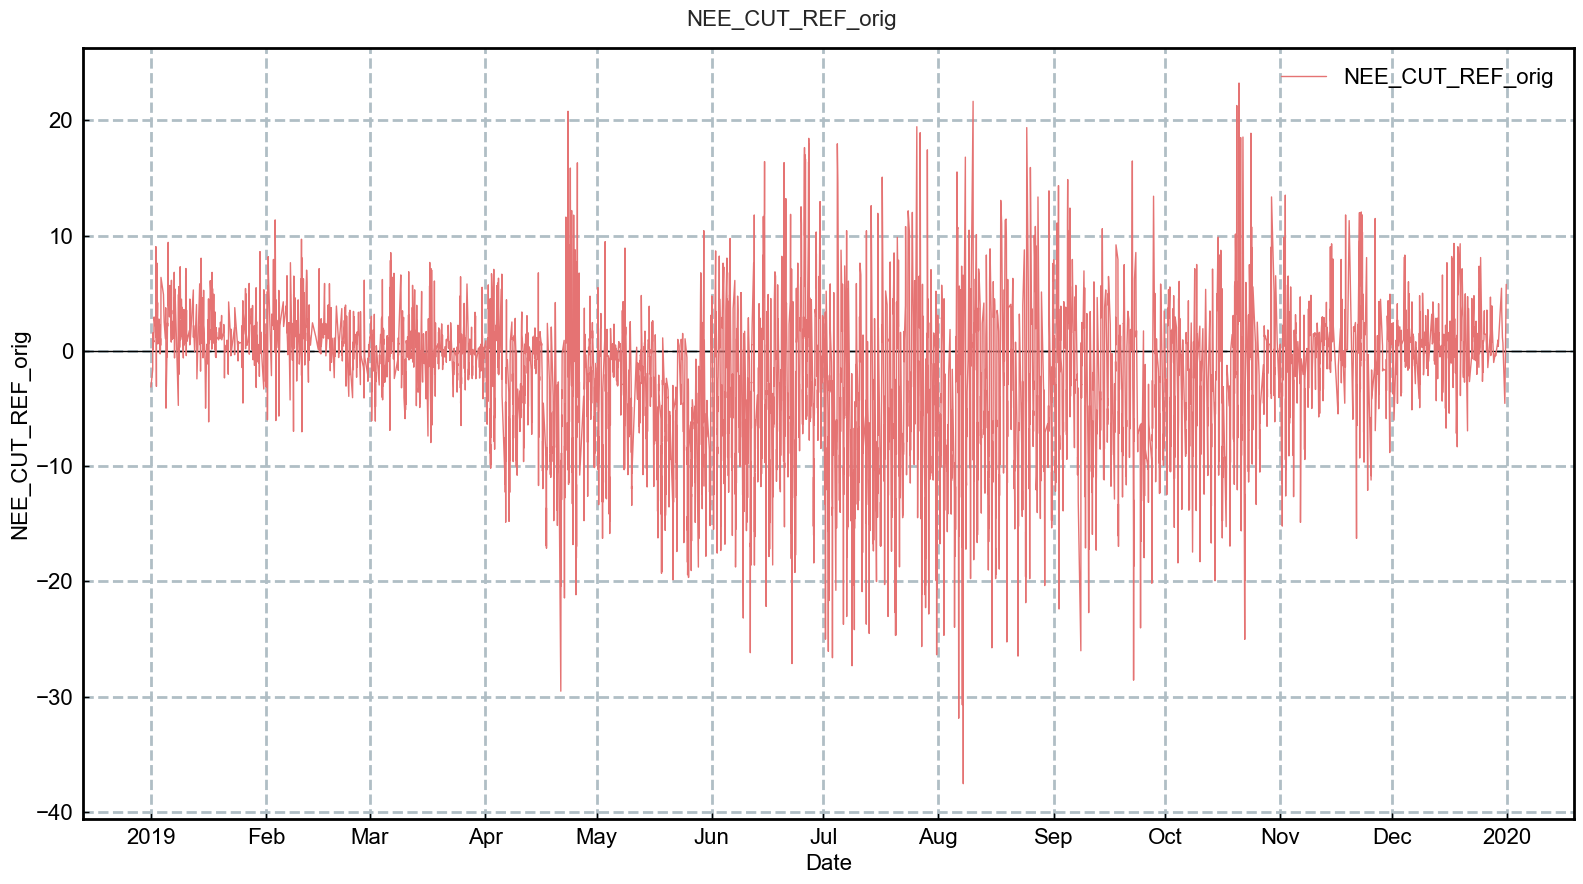

In [8]:
TimeSeries(series=subset[TARGET_COL]).plot()

In [9]:
TimeSeries(series=subset[TARGET_COL]).plot_interactive()

</br>

</br>

---

# **Parameter optimization**

## Initialize

In [10]:
# Random forest parameters
rf_params = {
    'n_estimators': list(range(5, 55, 5)),
    'criterion': ['squared_error'],
    'max_depth': [None],
    'min_samples_split': list(range(2, 12, 2)),
    'min_samples_leaf': list(range(1, 6, 1))
}

# Optimization
opt = OptimizeParamsRFTS(
    df=subset,
    target_col=TARGET_COL,
    **rf_params
)

</br>

## Optimize parameters

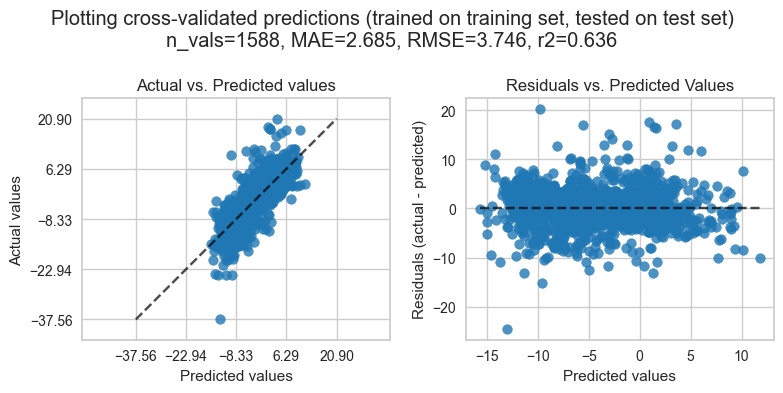

In [11]:
opt.optimize()

</br>

## Result

In [12]:
# Estimator which gave highest score (or smallest loss if specified) on the left out data
opt.best_params

{'criterion': 'squared_error',
 'max_depth': None,
 'min_samples_leaf': 5,
 'min_samples_split': 8,
 'n_estimators': 40}

In [13]:
# Return model scores for best model
opt.scores

{'mae': 2.685237937240783,
 'medae': 1.963995168268179,
 'mse': 14.035265994819282,
 'rmse': 3.7463670395223265,
 'mape': 1.998226626446616,
 'maxe': 24.49848971888843,
 'r2': 0.6364311500842185}

In [14]:
# Cross-validation results
opt.cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.103483,0.052728,0.001402,0.000490,squared_error,None,1,2,5,"{'criterion': 'squared_error', 'max_depth': No...",-22.027962,-22.499377,-21.092548,-18.062836,-22.390198,-18.147114,-19.901522,-20.011521,-22.113989,-17.036375,-20.328344,1.914047,250
1,0.194198,0.104953,0.002053,0.000569,squared_error,None,1,2,10,"{'criterion': 'squared_error', 'max_depth': No...",-20.472313,-20.072352,-21.446533,-18.682458,-19.459284,-17.461124,-19.726403,-16.761568,-18.971488,-15.365409,-18.841893,1.745921,243
2,0.292884,0.156129,0.002203,0.000332,squared_error,None,1,2,15,"{'criterion': 'squared_error', 'max_depth': No...",-19.482229,-19.001963,-20.085862,-17.985308,-19.957557,-16.063722,-19.560132,-16.964739,-18.767314,-14.984881,-18.285371,1.658442,229
3,0.387721,0.211407,0.002601,0.000663,squared_error,None,1,2,20,"{'criterion': 'squared_error', 'max_depth': No...",-19.178226,-19.872068,-19.947152,-18.297862,-18.708237,-16.805366,-19.388020,-17.346353,-18.420478,-14.379668,-18.234343,1.605927,227
4,0.486147,0.273298,0.002802,0.000677,squared_error,None,1,2,25,"{'criterion': 'squared_error', 'max_depth': No...",-19.104943,-19.483178,-19.747825,-17.022585,-18.715060,-16.129202,-19.100561,-16.270953,-17.738814,-14.250468,-17.756359,1.708115,208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,1.006587,0.557465,0.006362,0.009251,squared_error,None,5,10,30,"{'criterion': 'squared_error', 'max_depth': No...",-18.102603,-18.219794,-18.073977,-15.784654,-18.255735,-14.900286,-18.033361,-15.718611,-16.632021,-14.016561,-16.773760,1.501801,28
246,1.159512,0.696229,0.003308,0.000597,squared_error,None,5,10,35,"{'criterion': 'squared_error', 'max_depth': No...",-18.107203,-18.383451,-17.935784,-15.757563,-18.494698,-15.498941,-17.431145,-15.310153,-16.502479,-13.896071,-16.731749,1.491652,23
247,1.215423,0.594732,0.003752,0.000513,squared_error,None,5,10,40,"{'criterion': 'squared_error', 'max_depth': No...",-18.059118,-17.425604,-18.203764,-16.000044,-17.841972,-15.224985,-18.333042,-15.461318,-16.518129,-13.973692,-16.704167,1.423781,17
248,1.175014,0.531698,0.010605,0.019651,squared_error,None,5,10,45,"{'criterion': 'squared_error', 'max_depth': No...",-17.654285,-18.429216,-18.467425,-15.828724,-18.087256,-15.149579,-17.855179,-15.472253,-16.638103,-13.693708,-16.727573,1.548802,21


In [15]:
# Mean cross-validated score of the best_estimator
opt.best_score

-16.564781615900152

In [16]:
# The number of cross-validation splits (folds/iterations)
opt.cv_n_splits

10

</br>

## Plot

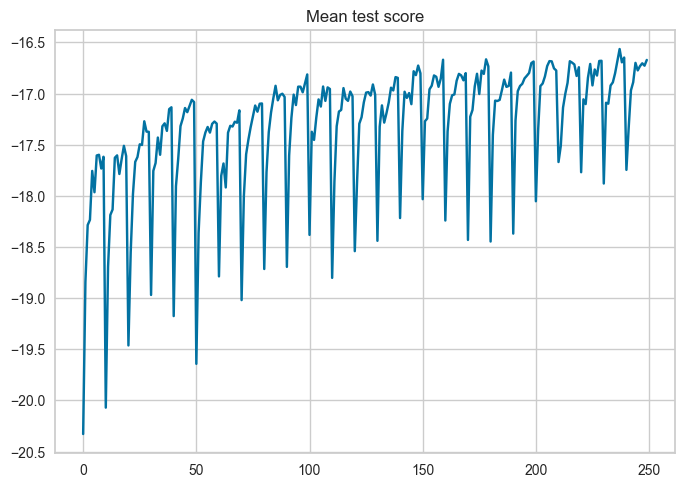

In [17]:
opt.cv_results['mean_test_score'].plot(title="Mean test score");

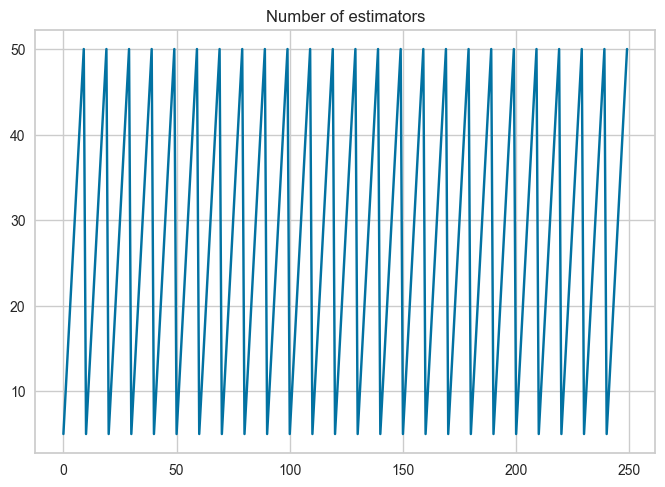

In [18]:
opt.cv_results['param_n_estimators'].plot(title="Number of estimators");

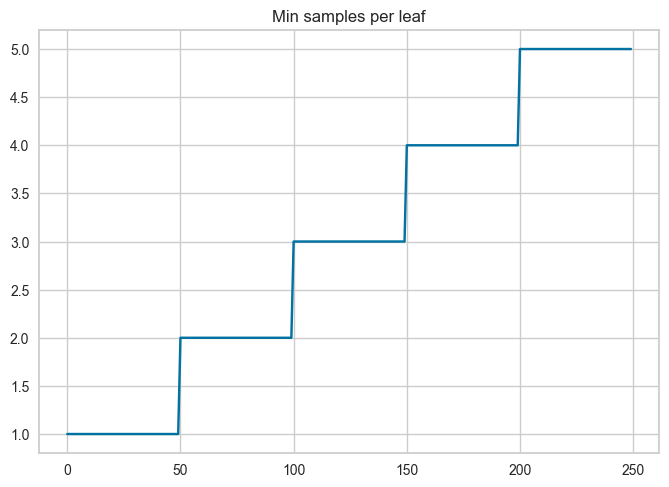

In [19]:
opt.cv_results['param_min_samples_leaf'].plot(title="Min samples per leaf");

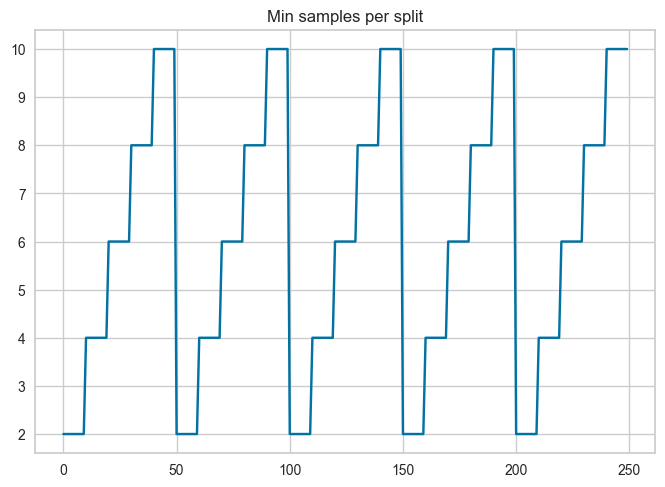

In [20]:
opt.cv_results['param_min_samples_split'].plot(title="Min samples per split");

</br>

# **End of notebook**
Congratulations, you reached the end of this notebook! Before you go let's store your finish time.

In [21]:
dt_string = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"Finished. {dt_string}")

Finished. 2023-09-17 00:53:40
